# Variational Autoencoder 

In [1]:
import warnings,os
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim # I lkie slim 
import matplotlib.pyplot as plt
# warnings.filterwarnings("ignore") # Stop showing annoying warnings
tf.logging.set_verbosity(tf.logging.ERROR) # I like old-style MNIST w/o warnings
from tensorflow.examples.tutorials.mnist import input_data
from util import gpu_sess
from vae_class import vae_class
%matplotlib inline
print ("TF version is [%s]."%(tf.__version__))

Instructions for updating:
Use the retry module or similar alternatives.
TF version is [1.7.0].


## Train Vanilla VAE (no conditioning, no weighting)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
[0000/10000][0.0%] Loss: 427.89(recon:392.38+kl:35.49+l2:0.02)


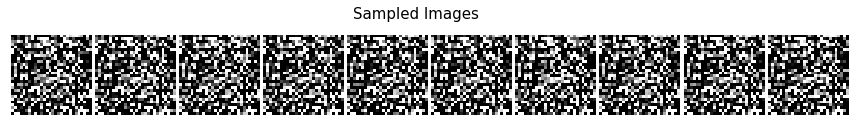

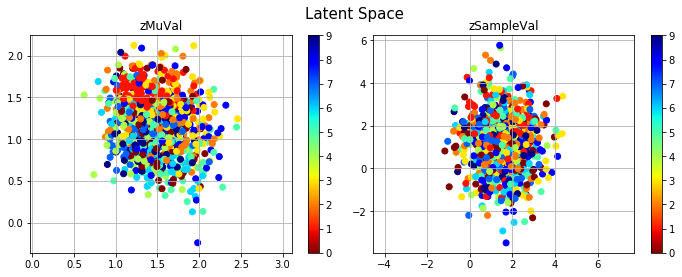

[9999/10000][100.0%] Loss: 29.25(recon:26.39+kl:2.81+l2:0.06)


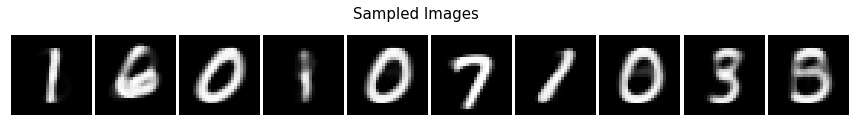

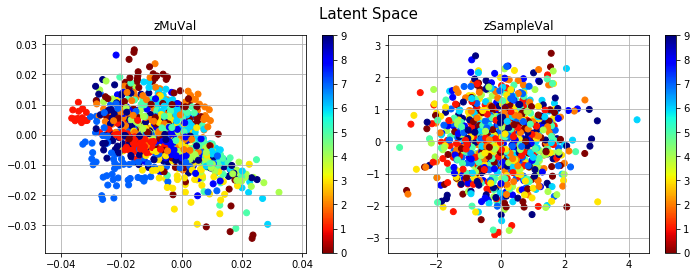

Done


In [2]:
tf.reset_default_graph() # Reset Graph 
tf.set_random_seed(0); np.random.seed(0) # Fix random seed 
V = vae_class(_name='VAE',_xDim=784,_zDim=16,_hDims=[256,128],_cDim=0, 
              _actv=tf.nn.softplus,_bn=None,
              _optimizer=tf.train.AdamOptimizer,
              _optm_param={'lr':0.001,'beta1':0.9,'beta2':0.9,'epsilon':1e-8},
              _VERBOSE=False)
sess = gpu_sess()
# We will use MNIST
mnist = input_data.read_data_sets('data', one_hot=True)
X = mnist.train.images
Y = mnist.train.labels
# Train Vanialla VAE
V.train(_sess=sess,_X=X,_Y=Y,_C=None,_Q=None,_maxIter=1e4,_batchSize=256,_PRINT_EVERY=2e4,_PLOT_EVERY=2e4,
       _imgSz=(28,28),_figsize=(15,2),_nR=1,_nC=10,_LR_SCHEDULE=False)
print ("Done")

Test and save weights

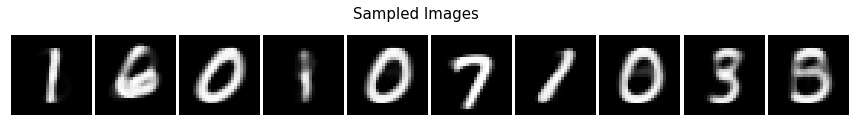

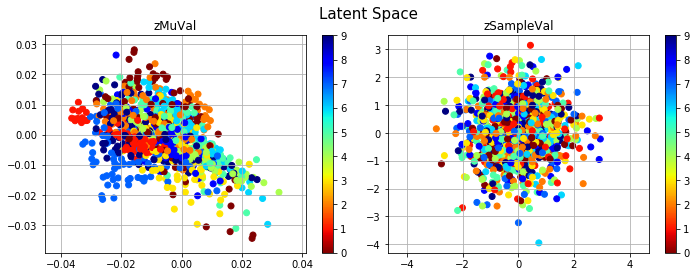

[nets/net_VAE.npz] Saved. Size is [8.3098]MB


In [3]:
V.test(_sess=sess,_nR=1,_nC=10,_C=None,_X=X,_Y=Y,_imgSz=(28,28),_figsize=(15,2))
V.save(_sess=sess,_VERBOSE=True)

Initialize weights and test

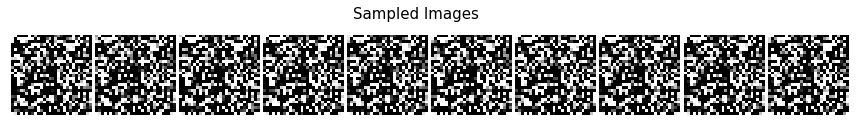

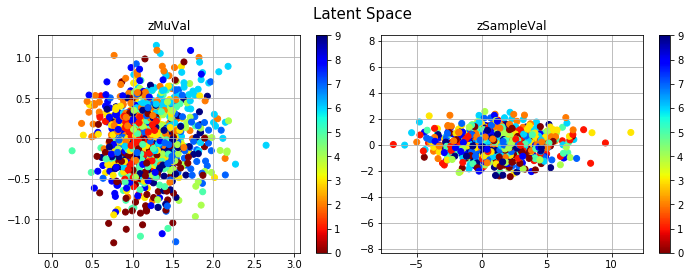

In [4]:
tf.reset_default_graph() # Reset Graph 
V2 = vae_class(_name='VAE',_xDim=784,_zDim=16,_hDims=[256,128],_cDim=0, 
              _actv=tf.nn.softplus,_bn=None,
              _optimizer=tf.train.AdamOptimizer,
              _optm_param={'lr':0.0001,'beta1':0.9,'beta2':0.9,'epsilon':1e-8},
              _VERBOSE=False)
sess = gpu_sess() # New session 
sess.run(tf.global_variables_initializer())
V2.test(_sess=sess,_nR=1,_nC=10,_C=None,_X=X,_Y=Y,_imgSz=(28,28),_figsize=(15,2))

Restore weights and test

Weight restored from [nets/net_VAE.npz] Size is [8.3098]MB


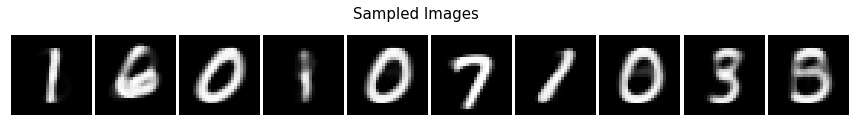

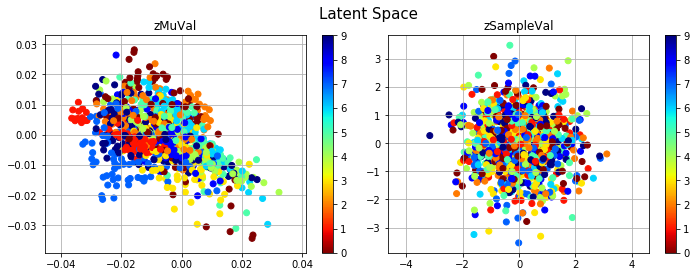

In [5]:
V2.restore(_sess=sess,_VERBOSE=True)
V2.test(_sess=sess,_nR=1,_nC=10,_C=None,_X=X,_Y=Y,_imgSz=(28,28),_figsize=(15,2))

## Train Conditional VAE (no weighting) 

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
[0000/10000][0.0%] Loss: 1073.41(recon:761.67+kl:311.72+l2:0.03)


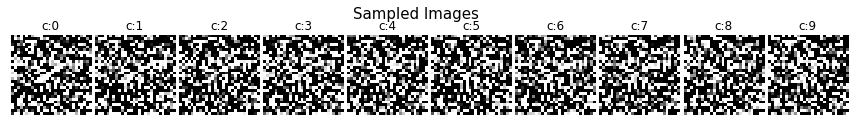

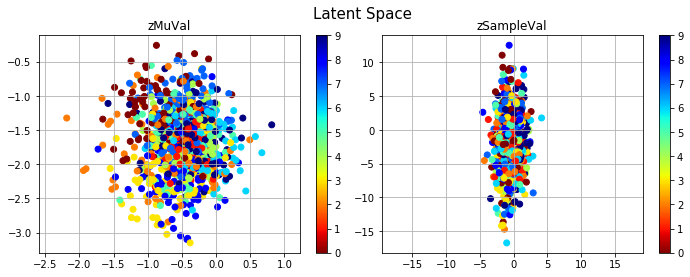

[9999/10000][100.0%] Loss: 31.74(recon:31.29+kl:0.43+l2:0.01)


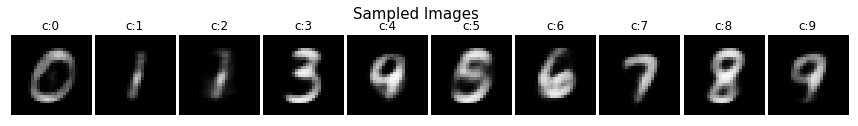

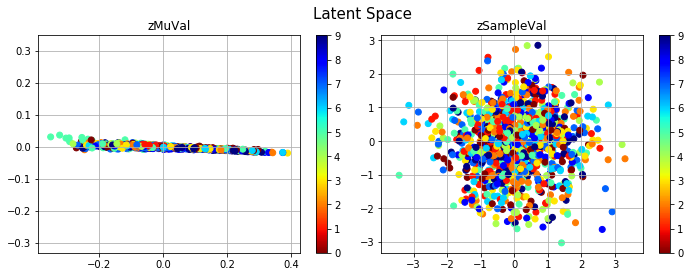

In [6]:
tf.reset_default_graph() # Reset Graph 
tf.set_random_seed(0); np.random.seed(0) # Fix random seed 
CV = vae_class(_name='CVAE',_xDim=784,_zDim=128,_hDims=[256,128],_cDim=10, 
              _actv=tf.nn.softplus,_bn=None,
              _optimizer=tf.train.AdamOptimizer,
              _optm_param={'lr':0.0001,'beta1':0.9,'beta2':0.9,'epsilon':1e-8},
              _VERBOSE=False)
sess = gpu_sess()
# We will use MNIST
mnist = input_data.read_data_sets('data', one_hot=True)
X = mnist.train.images
Y = mnist.train.labels
# Train Conditional VAE
CV.train(_sess=sess,_X=X,_Y=Y,_C=Y,_Q=None,_maxIter=1e4,_batchSize=256,_PRINT_EVERY=2e4,_PLOT_EVERY=2e4,
       _imgSz=(28,28),_figsize=(15,2),_nR=1,_nC=10,_LR_SCHEDULE=False)

## Train Conditional VAE with weighting Q
#### More weights to 0 than 4 and 5 than 9
 0,1,2,3,4 => 2,1,0,-1,-2
 
 5,6,7,8,9 => 2,1,0,-1,-2

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
[0000/10000][0.0%] Loss: 553.22(recon:392.28+kl:160.91+l2:0.03)


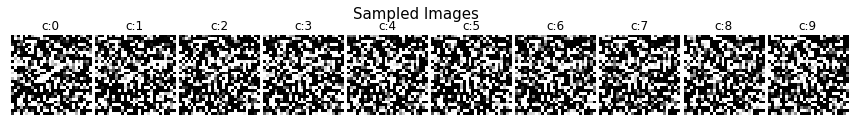

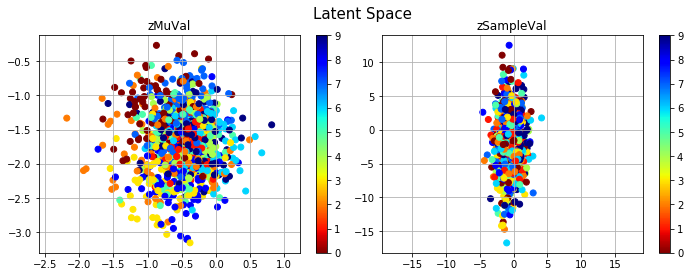

[9999/10000][100.0%] Loss: 10.53(recon:12.07+kl:-1.56+l2:0.02)


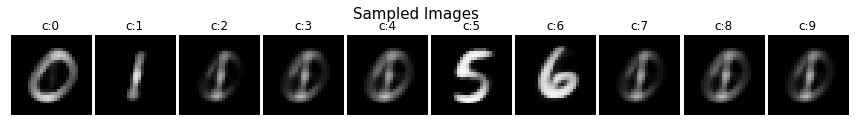

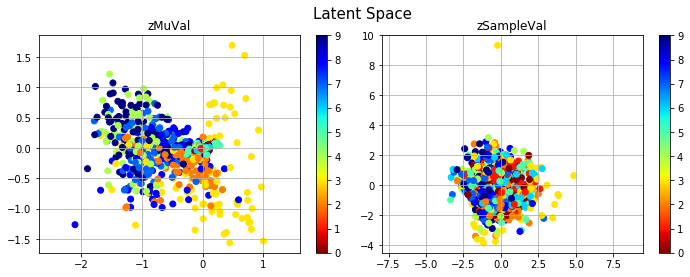

In [7]:
tf.reset_default_graph() # Reset Graph 
tf.set_random_seed(0); np.random.seed(0) # Fix random seed 
QV = vae_class(_name='QCVAE',_xDim=784,_zDim=128,_hDims=[256,128],_cDim=10, 
              _actv=tf.nn.softplus,_bn=None,
              _optimizer=tf.train.AdamOptimizer,
              _optm_param={'lr':0.0001,'beta1':0.9,'beta2':0.9,'epsilon':1e-8},
              _VERBOSE=False)
sess = gpu_sess()
# We will use MNIST
mnist = input_data.read_data_sets('data', one_hot=True)
X = mnist.train.images
Y = mnist.train.labels
Q = np.zeros(mnist.train.num_examples)
for i in range(mnist.train.num_examples):
    yVal = np.argmax(Y[i,:])
    if yVal<5: Q[i] = 2-yVal # 0,1,2,3,4 => 2,1,0,-1,-2
    else: Q[i] = 7-yVal # 5,6,7,8,9 => 2,1,0,-1,-2
# Train Conditional VAE with weighting
QV.train(_sess=sess,_X=X,_Y=Y,_C=Y,_Q=Q,_maxIter=1e4,_batchSize=256,_PRINT_EVERY=2e4,_PLOT_EVERY=2e4,
       _imgSz=(28,28),_figsize=(15,2),_nR=1,_nC=10,_LR_SCHEDULE=False)

## Train VAE with weighting Q
#### More weights to 0 than 4 and 5 than 9
 0,1,2,3,4 => 2,1,0,-1,-2
 
 5,6,7,8,9 => 2,1,0,-1,-2

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
[0000/30000][0.0%] Loss: 534.49(recon:373.55+kl:160.91+l2:0.03)


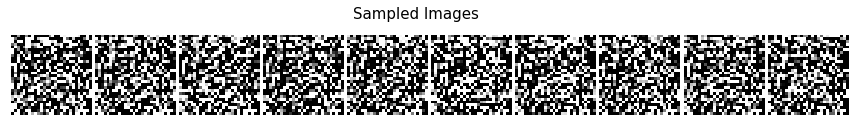

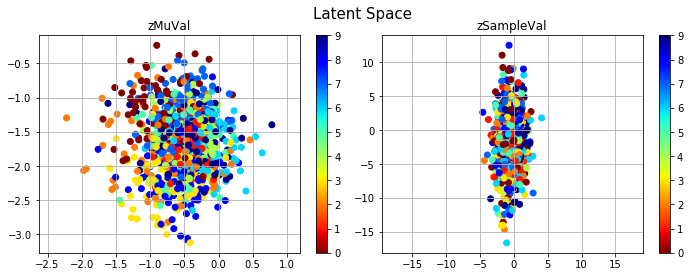

[5000/30000][16.7%] Loss: 10.62(recon:12.05+kl:-1.46+l2:0.02)


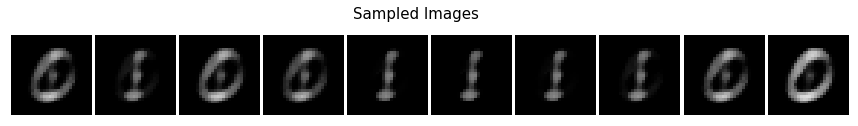

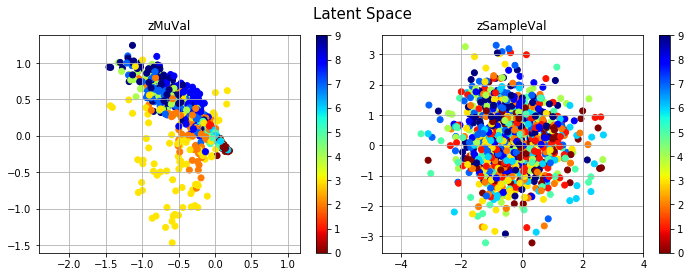

[10000/30000][33.3%] Loss: 10.18(recon:11.66+kl:-1.49+l2:0.02)


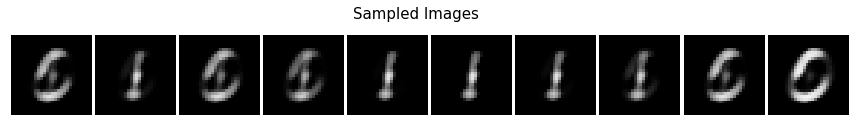

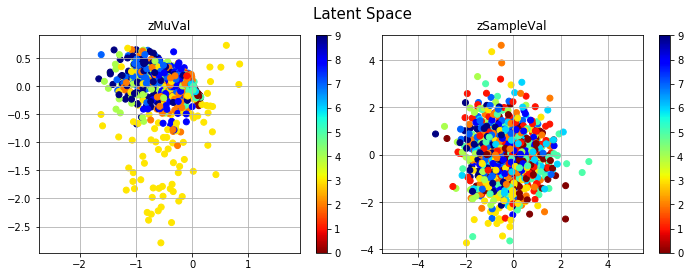

[15000/30000][50.0%] Loss: 9.81(recon:11.09+kl:-1.29+l2:0.02)


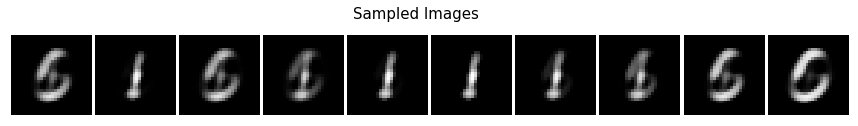

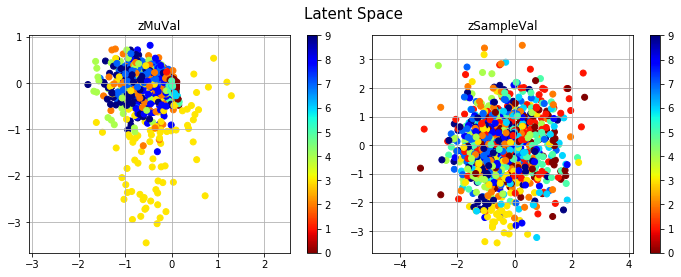

[20000/30000][66.7%] Loss: 9.55(recon:10.78+kl:-1.25+l2:0.02)


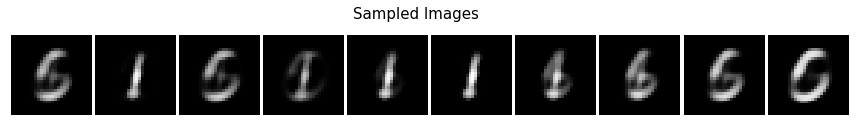

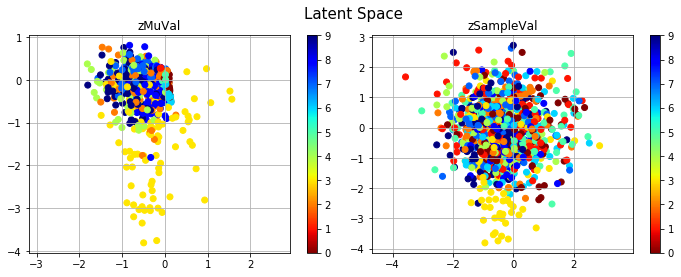

[25000/30000][83.3%] Loss: 9.33(recon:10.43+kl:-1.12+l2:0.02)


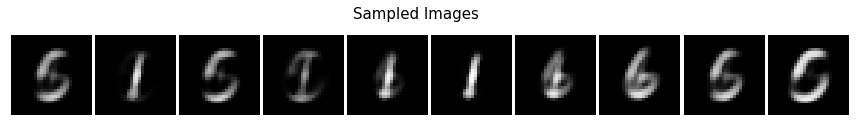

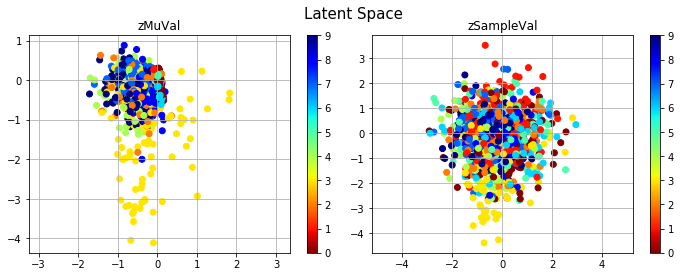

[29999/30000][100.0%] Loss: 9.40(recon:10.58+kl:-1.20+l2:0.02)


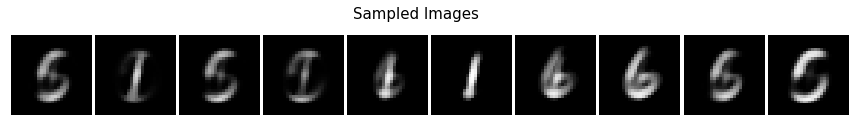

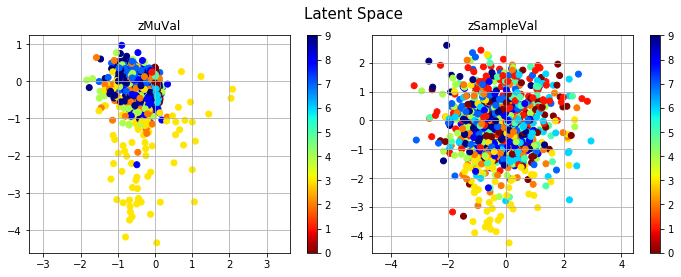

In [3]:
tf.reset_default_graph() # Reset Graph 
tf.set_random_seed(0); np.random.seed(0) # Fix random seed 
QV = vae_class(_name='QVAE',_xDim=784,_zDim=128,_hDims=[256,128],_cDim=0, 
              _actv=tf.nn.softplus,_bn=None,
              _optimizer=tf.train.AdamOptimizer,
              _optm_param={'lr':0.0001,'beta1':0.9,'beta2':0.9,'epsilon':1e-8},
              _VERBOSE=False)
sess = gpu_sess()
# We will use MNIST
mnist = input_data.read_data_sets('data', one_hot=True)
X = mnist.train.images
Y = mnist.train.labels
Q = np.zeros(mnist.train.num_examples)
for i in range(mnist.train.num_examples):
    yVal = np.argmax(Y[i,:])
    if yVal<5: Q[i] = 2-yVal # 0,1,2,3,4 => 2,1,0,-1,-2
    else: Q[i] = 7-yVal # 5,6,7,8,9 => 2,1,0,-1,-2
# Train Conditional VAE with weighting
QV.train(_sess=sess,_X=X,_Y=Y,_C=None,_Q=Q,_maxIter=3e4,_batchSize=256,_PRINT_EVERY=5e3,_PLOT_EVERY=5e3,
       _imgSz=(28,28),_figsize=(15,2),_nR=1,_nC=10,_LR_SCHEDULE=False)